<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).


Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение.
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [ ]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
# data = pd.read_csv("data/magic04.data", header=None)
data = pd.read_csv("/magic04.data", header=None) # я загружала в файлы коллаба отдельно, поэтому другой путь. сверху в комментариях путь, который был изначально
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [ ]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [ ]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [ ]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [ ]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [ ]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

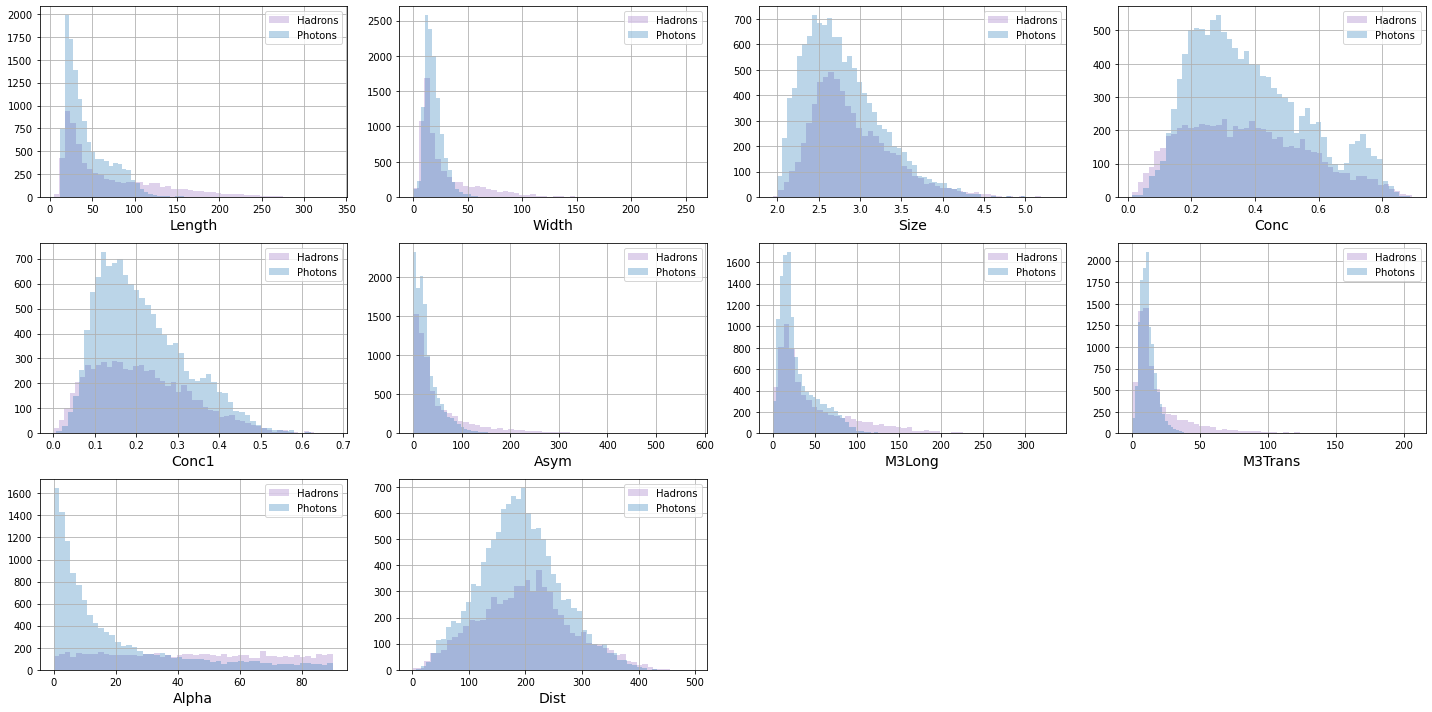

In [ ]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [ ]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size=0.5, shuffle = True, random_state = 11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

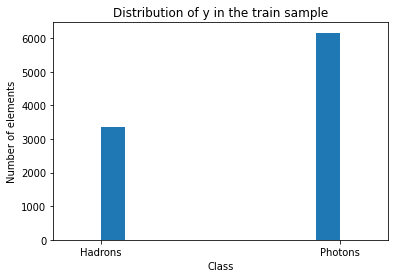

In [ ]:
plt.hist(y_train)
plt.xlabel('Class')
plt.ylabel('Number of elements')
plt.title('Distribution of y in the train sample')
plt.xlim(-0.2, 1.2)
plt.xticks([0,1], ['Hadrons', 'Photons']);

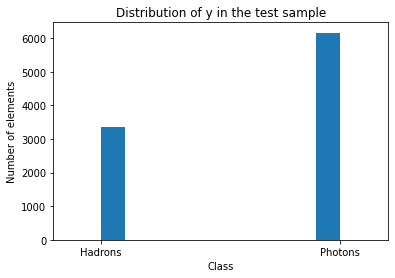

In [ ]:
plt.hist(y_test)
plt.xlabel('Class')
plt.ylabel('Number of elements')
plt.title('Distribution of y in the test sample')
plt.xlim(-0.2, 1.2)
plt.xticks([0,1], ['Hadrons', 'Photons']);

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [ ]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution='normal', random_state=5)
X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)

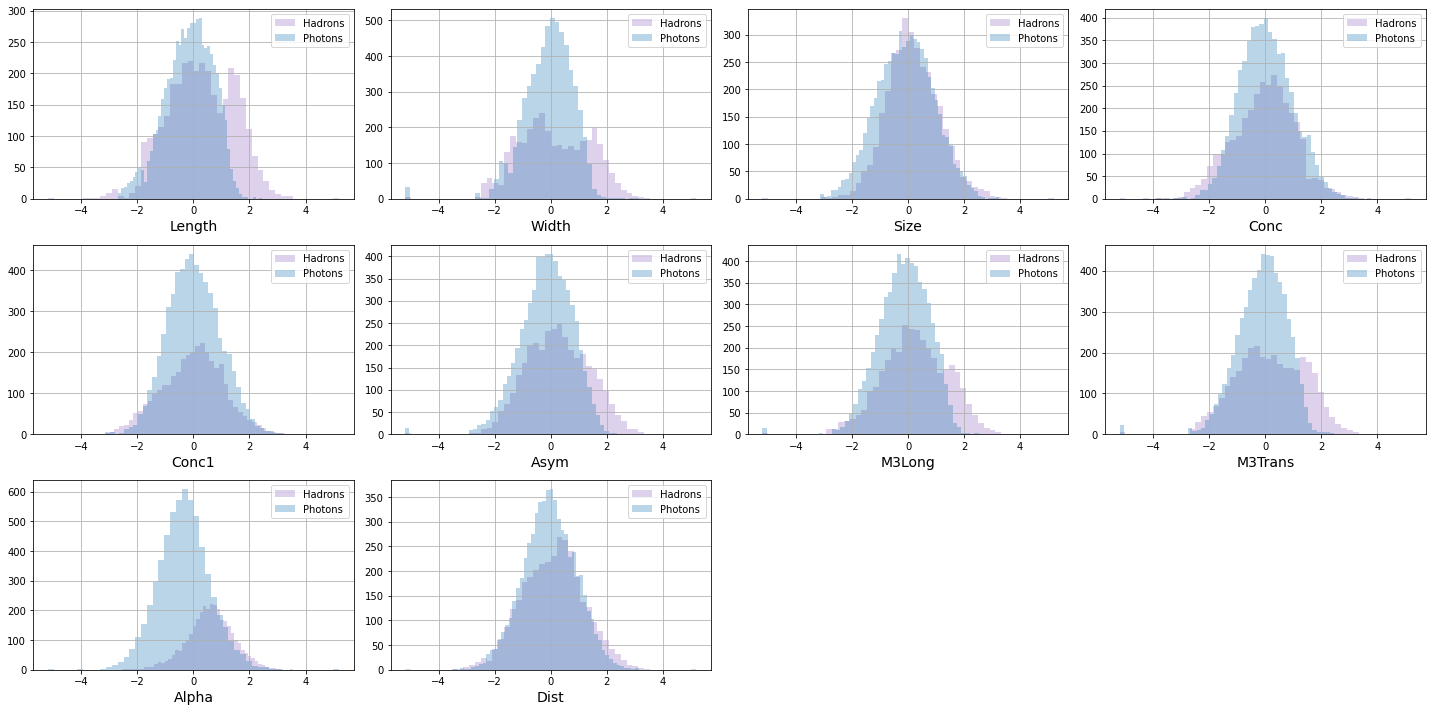

In [ ]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

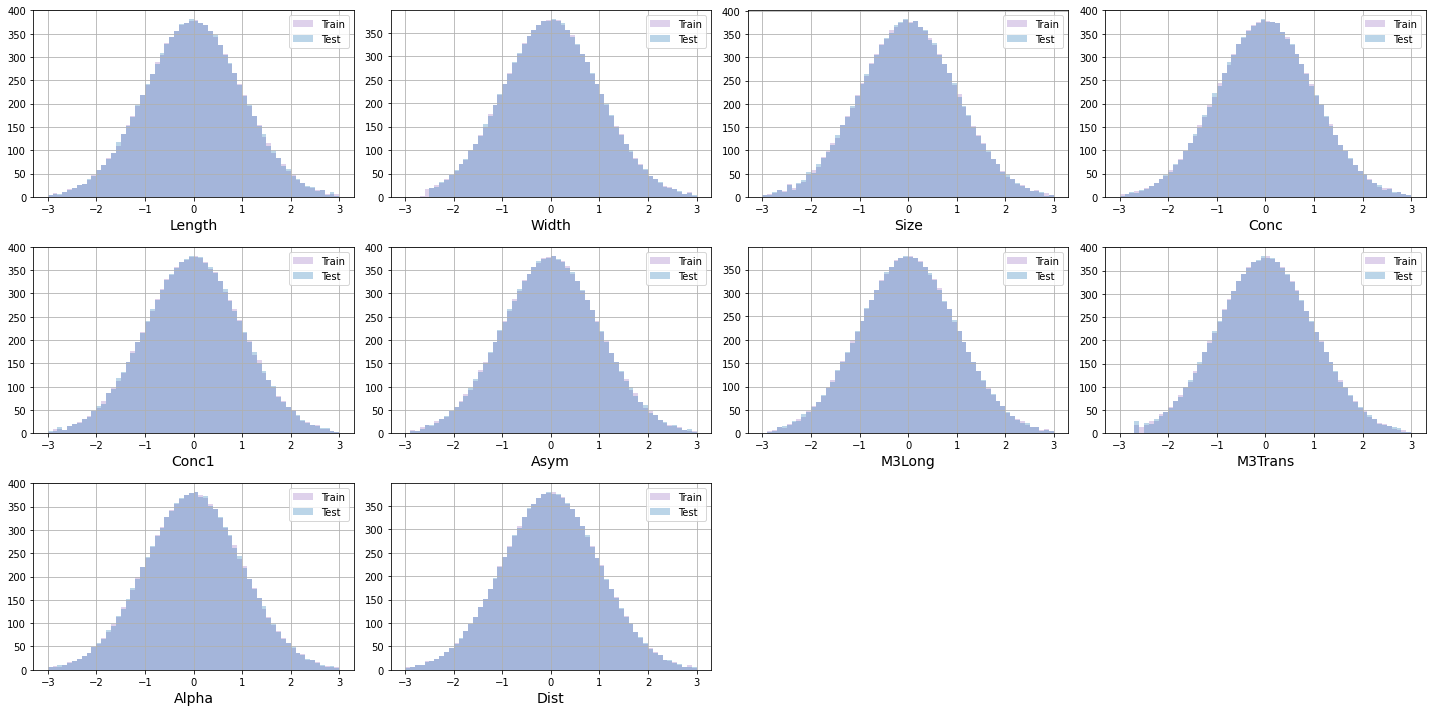

In [ ]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения.

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$.

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings("ignore")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
DEVICE

device(type='cuda')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [ ]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [ ]:
def generate(generator, y, latent_dim):

    z = torch.normal(0, 1, (len(y), latent_dim)).to('cuda') #генерируем вектор шума
    y = torch.tensor(y, dtype=torch.float32).to('cuda')
    X_fake = generator(z, y).cpu().detach().numpy() #генерируем новые объекты используя вектор шума и вектор условий, переводим в numpy

    return X_fake  # numpy

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()
        self.n_inputs = n_inputs
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Sigmoid() # мы будем определять класс объекта: 0 или 1. Область значений сигмоиды как раз [0, 1]
        )

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель линейной регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

def other_agent_score(X_real, y_real, X_fake, y_fake):

    # скеливаем X_real c y real, a X_fake c y_fake

    Xy_real = np.concatenate((X_real, y_real), axis=1) #теперь y стал признаком
    # аналогично для фейковых данных
    Xy_fake = np.concatenate((X_fake, y_fake), axis=1)

    # создаем столбцы из 1 по размеру реальных данных и из 0 по размеру фейковых данных
    ones_column = np.ones((Xy_real.shape[0], 1))
    zeros_column = np.zeros((Xy_fake.shape[0], 1))

    # а теперь склеиваем, теперь конкатенация по другой оси
    X = np.concatenate((Xy_real, Xy_fake), axis=0)
    y = np.concatenate((ones_column, zeros_column), axis=0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.33, shuffle = True, random_state = 11)

    logreg = LogisticRegression()
    boost = GradientBoostingClassifier()

    logreg.fit(X_train, y_train)
    boost.fit(X_train, y_train)

    logreg_predict = logreg.predict(X_test)
    boosting_predict = boost.predict(X_test)

    log_reg_score = accuracy_score(y_test, logreg_predict)
    boosting_score = accuracy_score(y_test, boosting_predict)

    print('Logistic regression score: ' + str(log_reg_score))
    print('Boosting score: ' + str(boosting_score))

Идеальное значение accuracy - 0.5. Это будет означать, что классифиакторы отличают фейковые данные от реальных с точностью случайного угадывания


## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Подсказка 1: не забывайте ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора.
- Подсказка 2: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 3: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [ ]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            iter_i = 0
            for i, (real_batch, cond_batch) in enumerate(DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)):


                # берем реальные объекты
                real_objects = real_batch
                y = cond_batch

                real_objects = real_objects.to(DEVICE)
                y = y.to(DEVICE)

                # генерируем фейковые объекты
                z_noise = torch.normal(0, 1, (len(real_objects), self.latent_dim)) # нормальный шум размера (50, 10)
                z_noise = z_noise.to(DEVICE)
                gen_objects = self.generator(z_noise, y)

                # считаем скоры
                real_objects_scores, gen_objects_scores = torch.split(discriminator(torch.cat([real_objects, gen_objects], dim=0),
                                                                                    torch.cat([y, y], dim=0) ), len(real_objects))

                #  обучаем генератор (обучаем его меньше шагов)
                if iter_i == 0 or self.n_critic % iter_i == 0:
                  self.opt_gen.zero_grad()
                  # gen_loss = torch.mean(self.discriminator(gen_objects, y))
                  gen_loss = torch.log(1 - gen_objects_scores).mean()
                  gen_loss.backward()
                  self.opt_gen.step()
                else:
                  self.opt_disc.zero_grad()
                  # discr_loss = torch.mean(self.discriminator(real_objects, y)) - torch.mean(self.discriminator(gen_objects, y))
                  discr_loss = - torch.log(real_objects_scores).mean() - torch.log(1 - gen_objects_scores).mean()
                  discr_loss.backward()
                  self.opt_disc.step()

                  # for p in self.discriminator.parameters():
                  #   p.data.clamp_(-0.01, 0.01)

                iter_i += 1

            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            Z_noise = Z_noise.to(DEVICE)
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(self.discriminator(X_fake, y_cond))
            self.loss_history.append(loss_epoch.detach().cpu())

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score (other_agent_score(X_real, y_real, X_fake, y_fake))

            X_train_sample = X_real[:1000].cpu().detach().numpy() #делаем срезы, чтобы быть уверенными в соответствии Х и y
            X_train_sample = X_real[:1000].cpu().detach().numpy()
            y_train_sample = y_cond[:1000].cpu().detach().numpy()
            X_fake_sample = X_fake[:1000].cpu().detach().numpy()
            y_fake_sample = y_train_sample

            other_agent_score(X_train_sample, y_train_sample, X_fake_sample, y_fake_sample)


        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [ ]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=200,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

Logistic regression score: 0.8560606060606061
Boosting score: 0.9621212121212122
Logistic regression score: 0.7833333333333333
Boosting score: 0.953030303030303
Logistic regression score: 0.7363636363636363
Boosting score: 0.9393939393939394
Logistic regression score: 0.6606060606060606
Boosting score: 0.9181818181818182
Logistic regression score: 0.6515151515151515
Boosting score: 0.9121212121212121
Logistic regression score: 0.6075757575757575
Boosting score: 0.8727272727272727
Logistic regression score: 0.603030303030303
Boosting score: 0.8803030303030303
Logistic regression score: 0.5969696969696969
Boosting score: 0.8575757575757575
Logistic regression score: 0.6212121212121212
Boosting score: 0.8560606060606061
Logistic regression score: 0.6212121212121212
Boosting score: 0.8469696969696969
Logistic regression score: 0.6454545454545455
Boosting score: 0.8590909090909091
Logistic regression score: 0.6318181818181818
Boosting score: 0.8333333333333334
Logistic regression score: 0.6

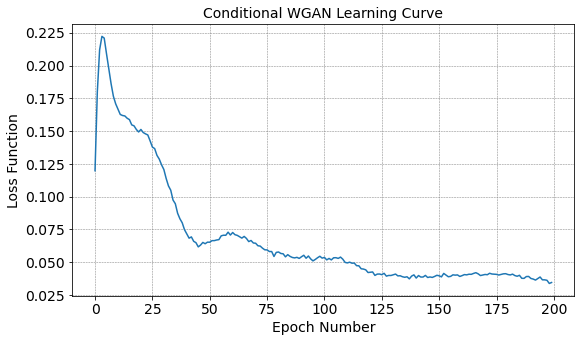

In [ ]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show();

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [ ]:
X_train_inv = qt.inverse_transform(X_train)
X_test_inv = qt.inverse_transform(X_test)

In [ ]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)
X_fake_train_inv = qt.inverse_transform(X_fake_train)

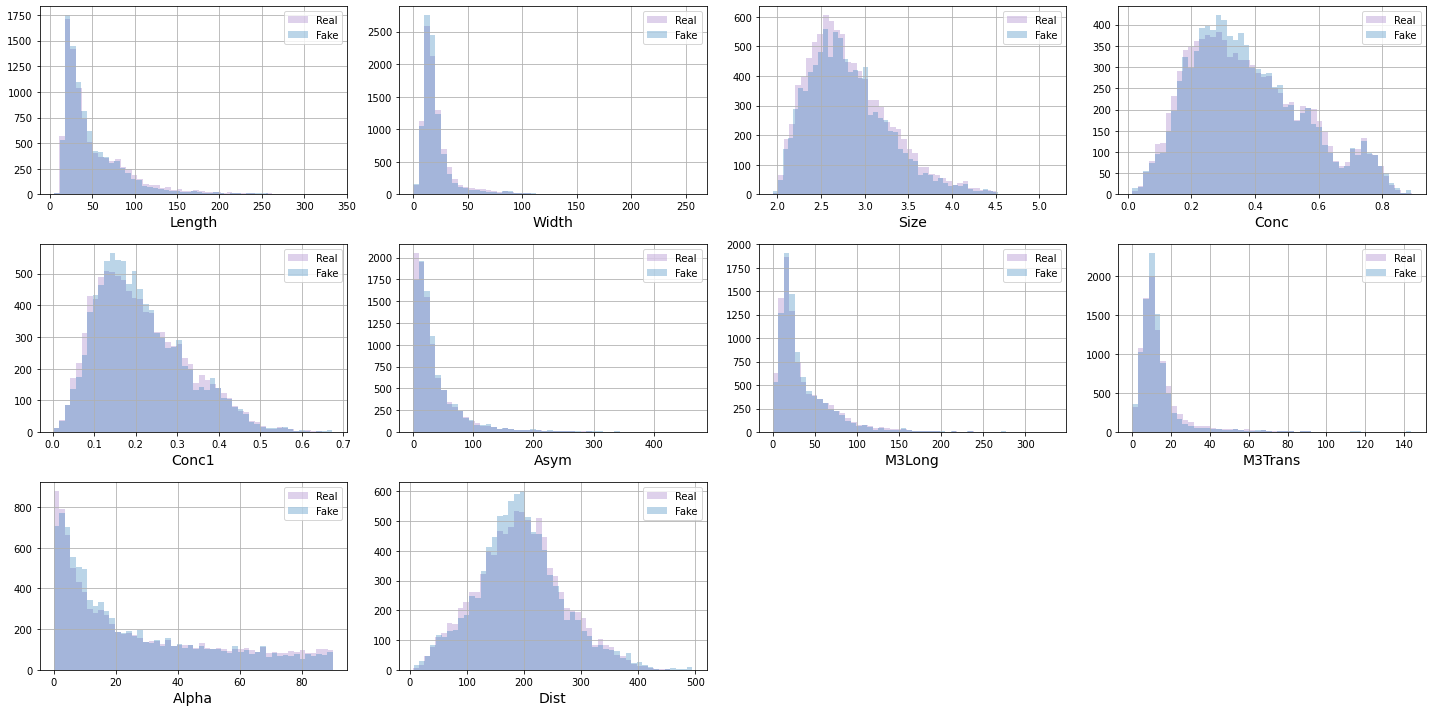

In [ ]:
plot_hists(X_train_inv, X_fake_train_inv, names, label1="Real", label2="Fake", bins=50)

In [ ]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)
X_fake_test_inv = qt.inverse_transform(X_fake_test)

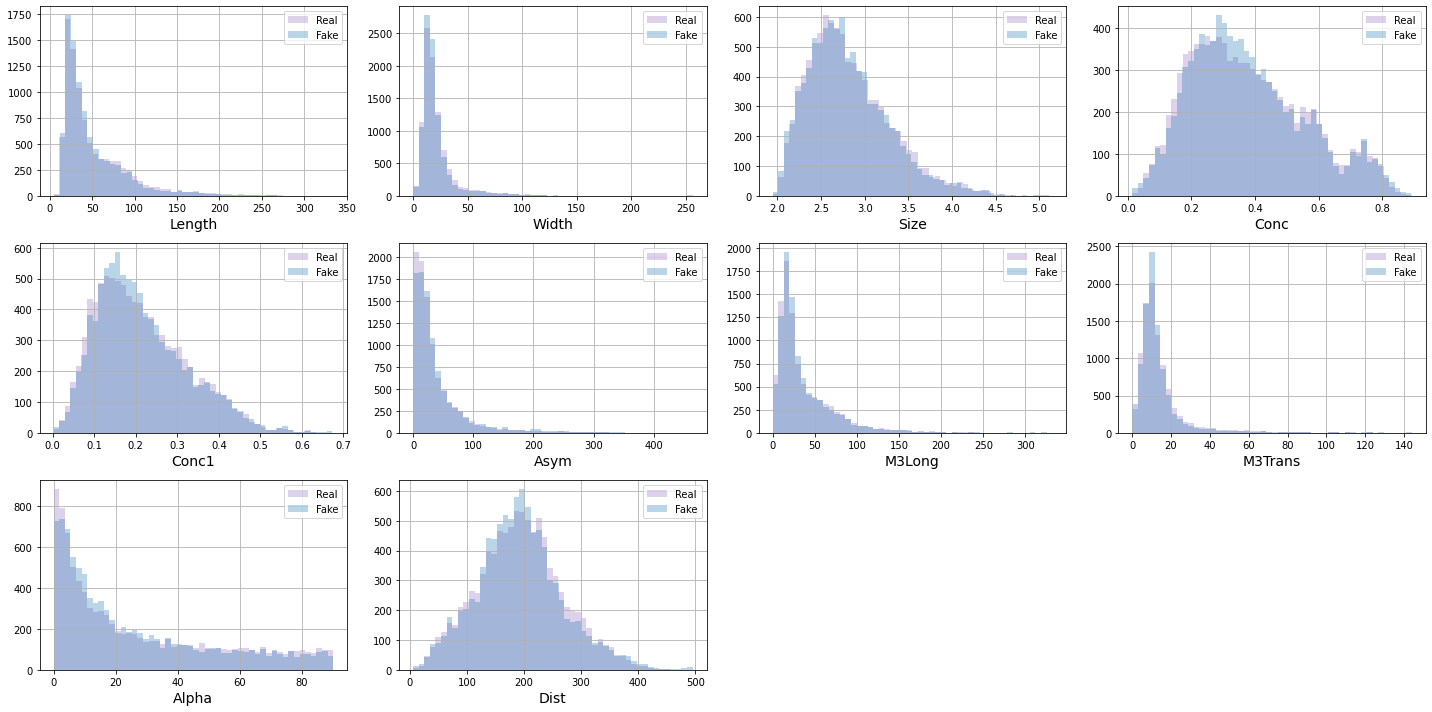

In [ ]:
plot_hists(X_test_inv, X_fake_test_inv, names, label1="Real", label2="Fake", bins=50)

## Вывод:
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [ ]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]
yy_test_pred = clf.predict(XX_test)

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
ac = accuracy_score(yy_test, yy_test_pred)
print("ROC AUC = ", auc)
print('accuracy =', ac)

ROC AUC =  0.7250059873883378
accuracy = 0.654626708727655


In [ ]:
logreg_clf = LogisticRegression()
logreg_clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba1 = logreg_clf.predict_proba(XX_test)[:, 1]
yy_test_pred1 = logreg_clf.predict(XX_test)
auc = roc_auc_score(yy_test, yy_test_proba1)
print("ROC AUC = ", auc)
ac = accuracy_score(yy_test, yy_test_pred1)
print('accuracy =', ac)

ROC AUC =  0.5523741570387471
accuracy = 0.5333859095688749


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


Налучшее значение ROC AUС - 0.5, оно будет означать, что классификатор совершенно не может разделить фейковые и реальные объекты (0.5 - вероятность случайного угадывания класса).

Ожидаемо, увеличение количества эпох улучшило качество GAN. Необычное наблюдение: без урезания весов дискриминатора ROC AUC И accuracy бустинга показывают лучшие результаты, поэтому этот кусок в коде закомментила.

Полученный ROC AUC = 0.73 не идеален, но тем не менее мне удалось в какой-то степени обмануть классификатор. Accuracy для бустинга: 0.65.
Также я посмотрела на accuracy и ROC AUC для логистической регрессии. Эту модель запутать проще и показатели для нее близки к идеальным. ROC AUC: 0.55, accuracy: 0.53

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

In [ ]:
!pip install -q diffusers

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [ ]:
def corrupt(x, amount):
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1)
    x = x*(1-amount) + noise*amount
    return x

## Добавим sсheduler, он пригодится вам при обучении модели

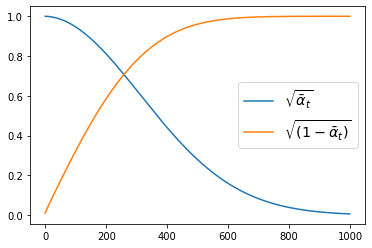

In [ ]:
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?).

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [ ]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [ ]:
def generate_with_diffusion(model, y, latent_dim, n_steps = 7): # убрала шедулер, добавила n_steps

    X_fake = torch.rand(len(y), latent_dim).to(DEVICE)
    y = torch.tensor(y, dtype=torch.float32).to('cuda')
    for i in range(n_steps):
      with torch.no_grad():
          pred = model(X_fake, y)
      mix_factor = 1 / (n_steps - i)
      X_fake = X_fake * (1 - mix_factor) + pred * mix_factor

    return X_fake.cpu().detach().numpy()

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [ ]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
        n_steps=5
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic
        self.n_steps = n_steps

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []


        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)):

                # берем реальные объекты
                real_objects = real_batch
                y = cond_batch
                real_objects = real_objects.to(DEVICE)
                y = y.to(DEVICE)

                noise = torch.randn_like(real_objects)
                noise_amount = torch.rand(real_objects.shape[0]).to(DEVICE)
                noisy_real_objects = corrupt(real_objects, noise_amount)

                pred = self.model(noisy_real_objects, y)
                loss = nn.MSELoss()
                gen_loss = loss(pred, real_objects)
                self.opt_gen.zero_grad()
                gen_loss.backward()
                self.opt_gen.step()

                loss_epoch += gen_loss.detach().cpu()


            # caiculate and store avg loss after an epoch

            self.loss_history.append(loss_epoch/i)

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            X_fake = torch.rand_like(X_real).to(DEVICE)
            for i in range(self.n_steps):
              with torch.no_grad():
                  pred = self.model(X_fake, y_cond)
              mix_factor = 1 / (self.n_steps - i)
              X_fake = X_fake * (1 - mix_factor) + pred * mix_factor


            X_train_sample = X_real[:1000].cpu().detach().numpy()
            y_train_sample = y_cond[:1000].cpu().detach().numpy()
            X_fake_sample = X_fake[:1000].cpu().detach().numpy()
            y_fake_sample = y_train_sample

            other_agent_score(X_train_sample, y_train_sample, X_fake_sample, y_fake_sample)

        # Turn off training
        self.model.train(False)

In [ ]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=32,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
    n_steps=7
)
diffusionFitter.fit(X_train, y_train)

Logistic regression score: 0.5196969696969697
Boosting score: 0.7242424242424242
Logistic regression score: 0.49393939393939396
Boosting score: 0.7363636363636363
Logistic regression score: 0.5333333333333333
Boosting score: 0.7257575757575757
Logistic regression score: 0.49696969696969695
Boosting score: 0.7181818181818181
Logistic regression score: 0.4893939393939394
Boosting score: 0.6848484848484848
Logistic regression score: 0.4984848484848485
Boosting score: 0.6712121212121213
Logistic regression score: 0.5151515151515151
Boosting score: 0.6757575757575758
Logistic regression score: 0.5136363636363637
Boosting score: 0.6712121212121213
Logistic regression score: 0.5227272727272727
Boosting score: 0.6545454545454545
Logistic regression score: 0.509090909090909
Boosting score: 0.6681818181818182
Logistic regression score: 0.4984848484848485
Boosting score: 0.6484848484848484
Logistic regression score: 0.5212121212121212
Boosting score: 0.6545454545454545
Logistic regression score: 

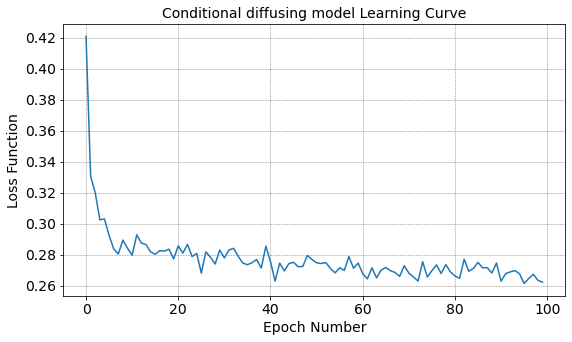

In [ ]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [ ]:
X_fake_diff_train = generate_with_diffusion(model, y_train, latent_dim)
X_fake_diff_test = generate_with_diffusion(model, y_test, latent_dim)
X_fake_diff_train_inv = qt.inverse_transform(X_fake_diff_train)
X_fake_diff_test_inv = qt.inverse_transform(X_fake_diff_test)

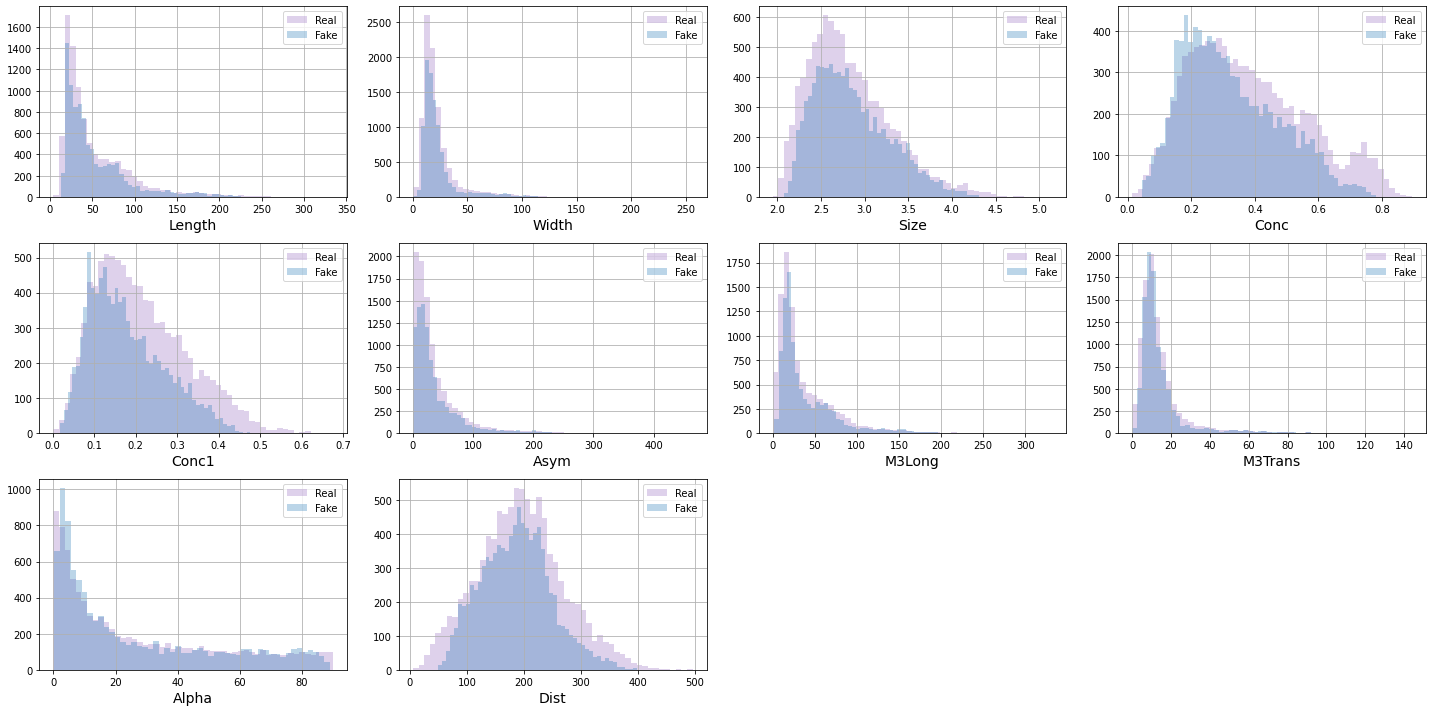

In [ ]:
plot_hists(X_train_inv, X_fake_diff_train_inv, names, label1="Real", label2="Fake", bins=50)

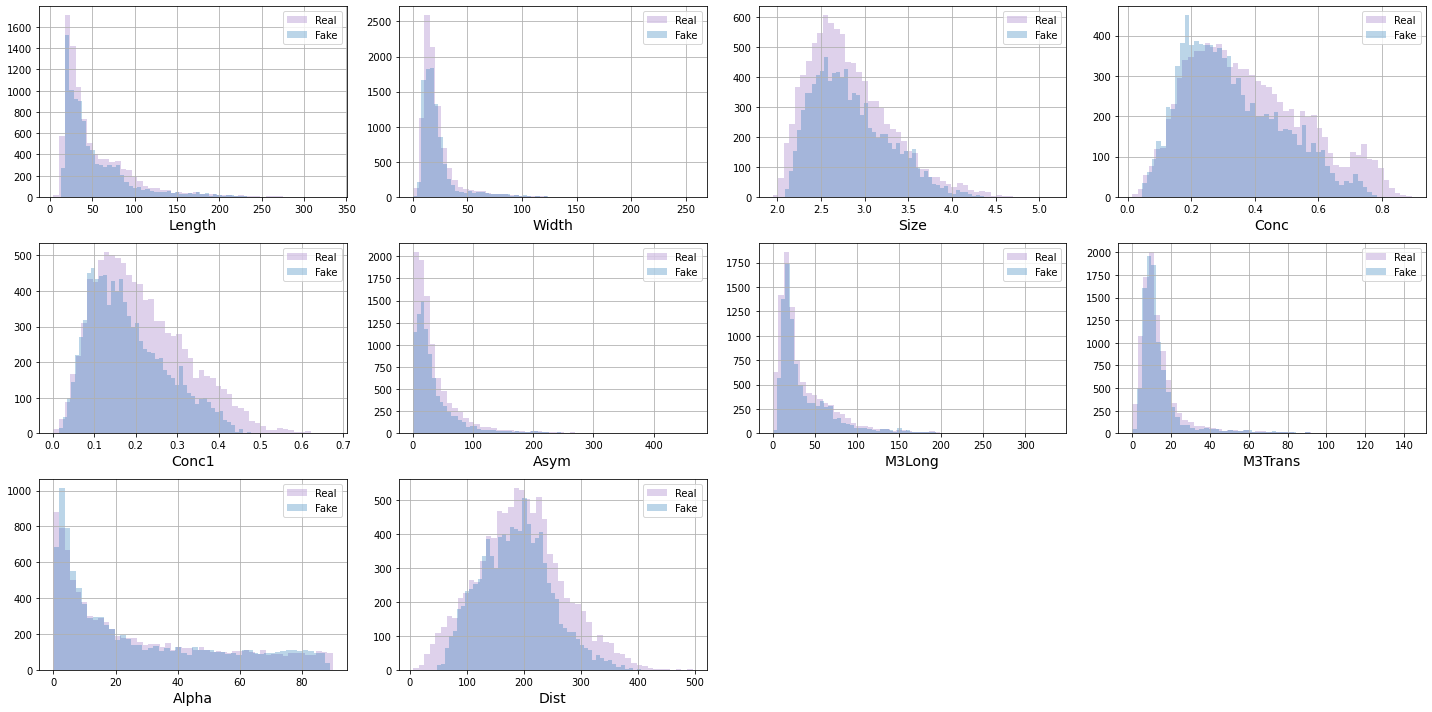

In [ ]:
plot_hists(X_test_inv, X_fake_diff_test_inv, names, label1="Real", label2="Fake", bins=50)

In [ ]:
XX_train_diff = np.concatenate((X_fake_diff_train, X_train), axis=0)
XX_test_diff = np.concatenate((X_fake_diff_test, X_test), axis=0)

yy_train_diff = np.array([0] * len(X_fake_diff_train) + [1] * len(X_train))
yy_test_diff = np.array([0] * len(X_fake_diff_test) + [1] * len(X_test))

In [ ]:
# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train_diff, yy_train_diff)

# получаем прогнозы
yy_test_proba_diff = clf.predict_proba(XX_test_diff)[:, 1]
yy_test_pred_diff = clf.predict(XX_test_diff)

In [ ]:
acc = accuracy_score(yy_test_diff, yy_test_pred_diff)
auc = roc_auc_score(yy_test_diff, yy_test_proba_diff)
print("ROC AUC =", auc)
print('accuracy =', acc)

ROC AUC = 0.8035254991978116
accuracy = 0.7294426919032597


In [ ]:
logreg_clf.fit(XX_train_diff, yy_train_diff)

# получаем прогнозы
yy_test_proba_diff1 = logreg_clf.predict_proba(XX_test_diff)[:, 1]
yy_test_pred_diff1 = logreg_clf.predict(XX_test_diff)
auc = roc_auc_score(yy_test_diff, yy_test_proba_diff1)
print("ROC AUC = ", auc)
ac = accuracy_score(yy_test_diff, yy_test_pred_diff1)
print('accuracy =', ac)

ROC AUC =  0.6824086881814593
accuracy = 0.6487907465825447


Результаты получились несколько хуже, чем с GAN-моделью. Для бустинга ROC AUC: 0.8, accuracy: 0.73. Это видно и на графиках распределения значений признаков. Возможно, для хорошего качества модели нам нужна более сложная архитектура, все таки я использовала простой вариант с функцией corrupt и не применяла шедулер. Немного улучшить ROC AUC позволил выбор количества шагов для генерации объекта: слишком много - не очень хорошо. Увеличение количества эпох результата не дало. Логистическую регрессию модель обманывает чуть лучше. Для нее ROC AUC: 0.68, accuracy: 0.65